# World Cup Analysis

In this notebook I present the code required to replicate my World Cup analysis post using event data.

## Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

from mplsoccer import Pitch, VerticalPitch

from PIL import Image
import urllib
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'DM Sans'

## Define SOC colormap

In [3]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

## Load the dataset

The following CSV file contains event level data for every match played during the 2022 FIFA World Cup.

In [4]:
data = pd.read_csv('data/world_cup_data.csv', index_col=0, low_memory=False)
data['qualifiers'] = [literal_eval(x) for x in data['qualifiers']]
data['satisfied_events_types'] = [literal_eval(x) for x in data['satisfied_events_types']]

## Viz 1. The player with most passes made during a single match

For our first chart we will look at the player that made the most passes during a single match in the World Cup (excluding extra-time).

Let's begin by performing some computations on our dataset to find which player fits the criteria and then proceed with our visual.

In [5]:
# Filter out corners and throw-ins.
data_passes = data.copy()
data_passes['is_throw_or_corner'] = False
for index, row in enumerate(data_passes['qualifiers']):
    for element in row:
        if 'ThrowIn' in element.keys() or 'CornerTaken' in element.keys():
            data_passes.at[index, 'is_throw_or_corner'] = True

In [6]:
data_most_passes = (
    data_passes[(data_passes['period'].isin(['FirstHalf', 'SecondHalf'])) & (data_passes['event_type'] == 'Pass') & (~data_passes['is_throw_or_corner'])]
    .groupby(['match_id', 'player_name', 'player_id', 'match_string']).size()
    .reset_index(name='total_passes')
    .sort_values(by='total_passes', ascending=False)
    .reset_index(drop=True)
)
player_most_passes = data_most_passes.loc[0]
print(f'The player with the most passes in a single match was {player_most_passes["player_name"]} in {player_most_passes["match_string"]}, with {player_most_passes["total_passes"]:.0f} passes made.')

The player with the most passes in a single match was Rodri in Japan - Spain, with 215 passes made.


In [7]:
# Filter conditions
condition_ft = data_passes['period'].isin(['FirstHalf', 'SecondHalf'])
condition_passes = data_passes['event_type'] == 'Pass'
condition_player = data_passes['player_id'] == player_most_passes['player_id']
condition_match = data_passes['match_id'] == player_most_passes['match_id']
# We create a new DataFrame
df_plot_passes = (
    data_passes[
        (condition_ft) & (condition_passes) &
        (condition_player) & (condition_match)
    ].reset_index(drop=True)
)
df_plot_passes.head()

,event_id,minute,second,team_id,x,y,expanded_minute,period,outcome_type,qualifiers,...,is_goal,player_name,event_type,pass_recipient,team_name,match_date,match_id,match_string,is_own_goal,is_throw_or_corner
0,2.488483e+09,0,15.0,338,14.7,17.3,0,FirstHalf,Successful,"[{'Angle': '1.3'}, {'Length': '30.6'}, {'Zone'...",...,NaN,Rodri,Pass,Pau Torres,Spain,2022-12-01T19:00:00,1632107,Japan - Spain,NaN,False
1,2.488483e+09,0,30.0,338,43.7,38.8,0,FirstHalf,Successful,"[{'StandingSave': True}, {'Length': '18.5'}, {...",...,NaN,Rodri,Pass,Pau Torres,Spain,2022-12-01T19:00:00,1632107,Japan - Spain,NaN,False
2,2.488483e+09,0,38.0,338,44.0,42.7,0,FirstHalf,Successful,"[{'Length': '19.1'}, {'PassEndY': '14.8'}, {'P...",...,NaN,Rodri,Pass,César Azpilicueta,Spain,2022-12-01T19:00:00,1632107,Japan - Spain,NaN,False
3,2.488483e+09,0,47.0,338,34.9,44.2,0,FirstHalf,Successful,"[{'PassEndX': '26.5'}, {'Zone': 'Back'}, {'Sta...",...,NaN,Rodri,Pass,Pau Torres,Spain,2022-12-01T19:00:00,1632107,Japan - Spain,NaN,False
4,2.488483e+09,0,57.0,338,38.7,28.3,0,FirstHalf,Successful,"[{'Zone': 'Back'}, {'StandingSave': True}, {'A...",...,NaN,Rodri,Pass,Pau Torres,Spain,2022-12-01T19:00:00,1632107,Japan - Spain,NaN,False


Next, we check which passes were progressive, i.e. passes that ended within the opposition box or which took the ball closer to the opposition's center of the goal by 25%.

In [8]:
def check_if_pass_is_progressive(x, y, end_x, end_y):
    '''
    This function returns "True" if the pass meets the criteria
    for a progressive pass.
    '''
    # -- Start position
    height_start = abs(x - 100)
    length_start = abs(y - 50)
    distance_sq_start = height_start**2 + length_start**2
    distance_start = distance_sq_start**(1/2)
    # -- End position
    height_end = abs(end_x - 100)
    length_end = abs(end_y - 50)
    distance_sq_end = height_end**2 + length_end**2
    distance_end = distance_sq_end**(1/2)
    # -- Calculate change in distance
    delta_distance = distance_end/distance_start - 1
    if delta_distance <= -0.25:
        return True
    else:
        return False

In [9]:
df_plot_passes['is_progressive'] = df_plot_passes.apply(lambda x: check_if_pass_is_progressive(x['x'], x['y'], x['end_x'], x['end_y']), axis=1)

Next, we can proceed to make our visual

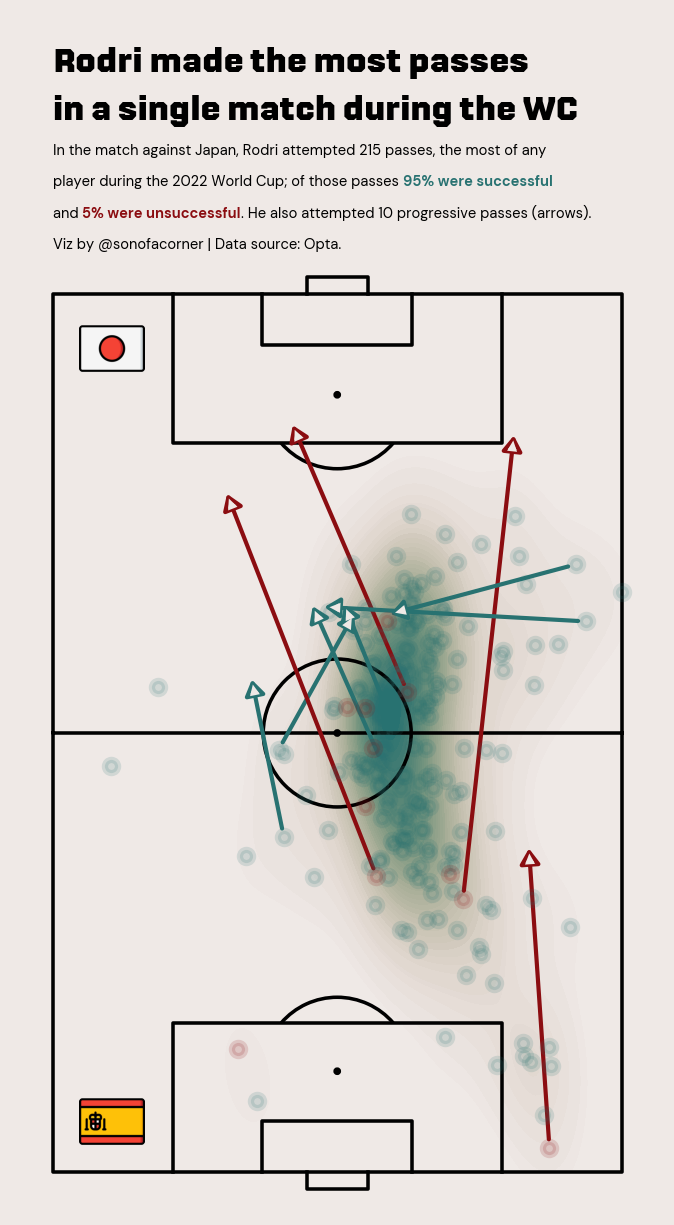

In [121]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=.85,
    line_color='black',
)
pitch.draw(ax = ax)

# - We need to invert the coordinates because of the Vertical Pitch!!
for index, pass_made in df_plot_passes.iterrows():
    if pass_made['is_progressive']:
        if pass_made['outcome_type'] == 'Successful':
            color = '#287271'
        else:
            color = '#8B0D11'
        x = pass_made['y']
        y = pass_made['x']
        dx = pass_made['end_y']
        dy = pass_made['end_x']
        pass_arrow = mpatches.FancyArrowPatch((x,y), (dx, dy), ec='None',
                                            fc='#efe9e6',arrowstyle='-|>,head_length=2.6,head_width=1.2', zorder=4)
        ax.add_patch(pass_arrow)
        pass_arrow = mpatches.FancyArrowPatch((x,y), (dx, dy), ec=color,
                                            fc='None',arrowstyle='-|>,head_length=3,head_width=2', zorder=2)
        ax.add_patch(pass_arrow)

pitch.kdeplot(
    df_plot_passes.x, df_plot_passes.y, 
    ax=ax, shade=True, 
    levels=50, shade_lowest=True,
    cut=4, zorder=-1, cmap='SOC')

# -- We plot the scatter (also with inverted coords)
df_plot_passes_succ = df_plot_passes[df_plot_passes['outcome_type'] == 'Successful']
df_plot_passes_unsucc = df_plot_passes[df_plot_passes['outcome_type'] != 'Successful']
ax.scatter(df_plot_passes_succ.y, df_plot_passes_succ.x, s=10, alpha=0.15, lw=1.5, color='#287271', zorder=3)
ax.scatter(df_plot_passes_unsucc.y, df_plot_passes_unsucc.x, s=10, alpha=0.15, lw=1.5, color='#8B0D11', zorder=3)

# -- Add Fancy Logo and Text
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
ax_coords = DC_to_NFC((80,2))
ax_size = .055
image_ax = fig.add_axes(
    [ax_coords[0], ax_coords[1], ax_size, ax_size],
    fc='None'
)
fotmob_url = 'https://cdn-icons-png.flaticon.com/512/939/939640.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax_coords = DC_to_NFC((80,90))
ax_size = .055
image_ax = fig.add_axes(
    [ax_coords[0], ax_coords[1], ax_size, ax_size],
    fc='None'
)
fotmob_url = 'https://cdn-icons-png.flaticon.com/512/939/939616.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax_text(
    x=100, y=119,
    s='<Rodri> made the most passes\nin a single match during the WC',
    size=8, family='Nippo',
    ha='left', ax=ax, va='bottom', weight='bold'
)

succes_rate = df_plot_passes_succ.shape[0]/(df_plot_passes.shape[0])

str_text = f'''
In the match against Japan, Rodri attempted 215 passes, the most of any
player during the 2022 World Cup; of those passes <{succes_rate:.0%} were successful>
and <{1-succes_rate:.0%} were unsuccessful>. He also attempted {df_plot_passes[df_plot_passes["is_progressive"]].shape[0]:.0f} progressive passes (arrows).
Viz by @sonofacorner | Data source: Opta.
'''

ax_text(
    x=100, y=119,
    s=str_text,
    size=3.5, family='DM Sans', 
    highlight_textprops=[{'color':'#287271', 'weight':'bold'}, {'color':'#8B0D11', 'weight':'bold'}],
    ha='left', ax=ax, va='top'
)

plt.savefig(
	"figures/12232022_most_passes.png",
	dpi = 600,
	facecolor = "None",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

## Viz 2. Teams with Most Recoveries in the Opposing Final Third

Next, we will look at which team had the most number of recoveries of the ball in the opposition's final third.

In [ ]:
# We define a set that covers all (I think) recovery ball actions:
recovery_set = set(['ballRecovery','interceptionWon','tackleWon','foulGiven','duelAerialWon'])
data_recoveries = data.copy()
data_recoveries['won_possession'] = False
for index, row in enumerate(data_recoveries['satisfied_events_types']):
    set_element = set(row)
    if len(recovery_set.intersection(set_element)) > 0:
        data_recoveries.at[index, 'won_possession'] = True

For the next step, we check filter only those recoveries that happened in the opposition's final third.

In [ ]:
data_recoveries = data_recoveries[data_recoveries['won_possession']]
data_recoveries = data_recoveries[data_recoveries['x'] > 100 - 100/3].reset_index(drop=True)

Finally, we group the data to check the team that had the most recoveries in the final third.

In [ ]:
data_most_recoveries = (
    data_recoveries[(data_recoveries['period'].isin(['FirstHalf', 'SecondHalf']))]
    .groupby(['match_id', 'team_name', 'team_id', 'match_string']).size()
    .reset_index(name='total_recoveries')
    .sort_values(by='total_recoveries', ascending=False)
    .reset_index(drop=True)
)
data_most_recoveries.sort_values(by='total_recoveries')

,match_id,team_name,team_id,match_string,total_recoveries
127,1632119,Switzerland,423,Serbia - Switzerland,2
123,1638014,Wales,421,Wales - England,3
126,1697162,Netherlands,335,Netherlands - USA,3
125,1632105,Japan,986,Germany - Japan,3
124,1697399,South Korea,1159,Brazil - South Korea,3
...,...,...,...,...,...
4,1632102,Denmark,425,Denmark - Tunisia,21
3,1632101,Mexico,972,Saudi Arabia - Mexico,23
2,1638013,Wales,421,Wales - Iran,23
1,1632105,Germany,336,Germany - Japan,23


Time to do the visual.

In [ ]:
data_eng = data_recoveries[(data_recoveries['match_id'] == 1697726) & (data_recoveries['team_id'] == 345)]
data_eng.head()

,event_id,minute,second,team_id,x,y,expanded_minute,period,outcome_type,qualifiers,...,is_goal,player_name,event_type,pass_recipient,team_name,match_date,match_id,match_string,is_own_goal,won_possession
1338,2.490214e+09,2,45.0,345,68.4,39.8,2,FirstHalf,Successful,[],...,NaN,Bukayo Saka,BallRecovery,NaN,England,2022-12-10T19:00:00,1697726,England - France,NaN,True
1339,2.490214e+09,3,12.0,345,76.2,14.7,3,FirstHalf,Successful,[],...,NaN,Jordan Henderson,BallRecovery,NaN,England,2022-12-10T19:00:00,1697726,England - France,NaN,True
1340,2.490215e+09,4,23.0,345,71.1,94.7,4,FirstHalf,Successful,"[{'Foul': True}, {'Offensive': True}, {'Opposi...",...,NaN,Phil Foden,Foul,NaN,England,2022-12-10T19:00:00,1697726,England - France,NaN,True
1342,2.490218e+09,18,42.0,345,76.9,33.0,18,FirstHalf,Successful,"[{'Zone': 'Center'}, {'OppositeRelatedEvent': ...",...,NaN,Bukayo Saka,Foul,NaN,England,2022-12-10T19:00:00,1697726,England - France,NaN,True
1343,2.490218e+09,21,33.0,345,96.7,56.8,21,FirstHalf,Successful,"[{'Zone': 'Center'}, {'OppositeRelatedEvent': ...",...,NaN,Jude Bellingham,Aerial,NaN,England,2022-12-10T19:00:00,1697726,England - France,NaN,True


However, first we need to get the coordinates of the pitch to specify the bounds of the bins we'll use to cut the data

In [ ]:
pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=.85,
    line_color='black',
    half=True
)

# Here we can get the positional dimensions
pos_x = pitch.dim.positional_x
pos_y = pitch.dim.positional_y

In [ ]:
data_eng = data_eng.assign(bins_x = lambda x: pd.cut(x.x, bins=pos_x))
data_eng = data_eng.assign(bins_y = lambda x: pd.cut(x.y, bins=pos_y))
data_eng_groupped = data_eng.groupby(['bins_x', 'bins_y']).size().reset_index(name='count')
data_eng_groupped['left_x'] = data_eng_groupped['bins_x'].apply(lambda x: x.left)
data_eng_groupped['right_x'] = data_eng_groupped['bins_x'].apply(lambda x: x.right)
data_eng_groupped['left_y'] = data_eng_groupped['bins_y'].apply(lambda x: x.left)
data_eng_groupped['right_y'] = data_eng_groupped['bins_y'].apply(lambda x: x.right)

Finally, we do our visual.

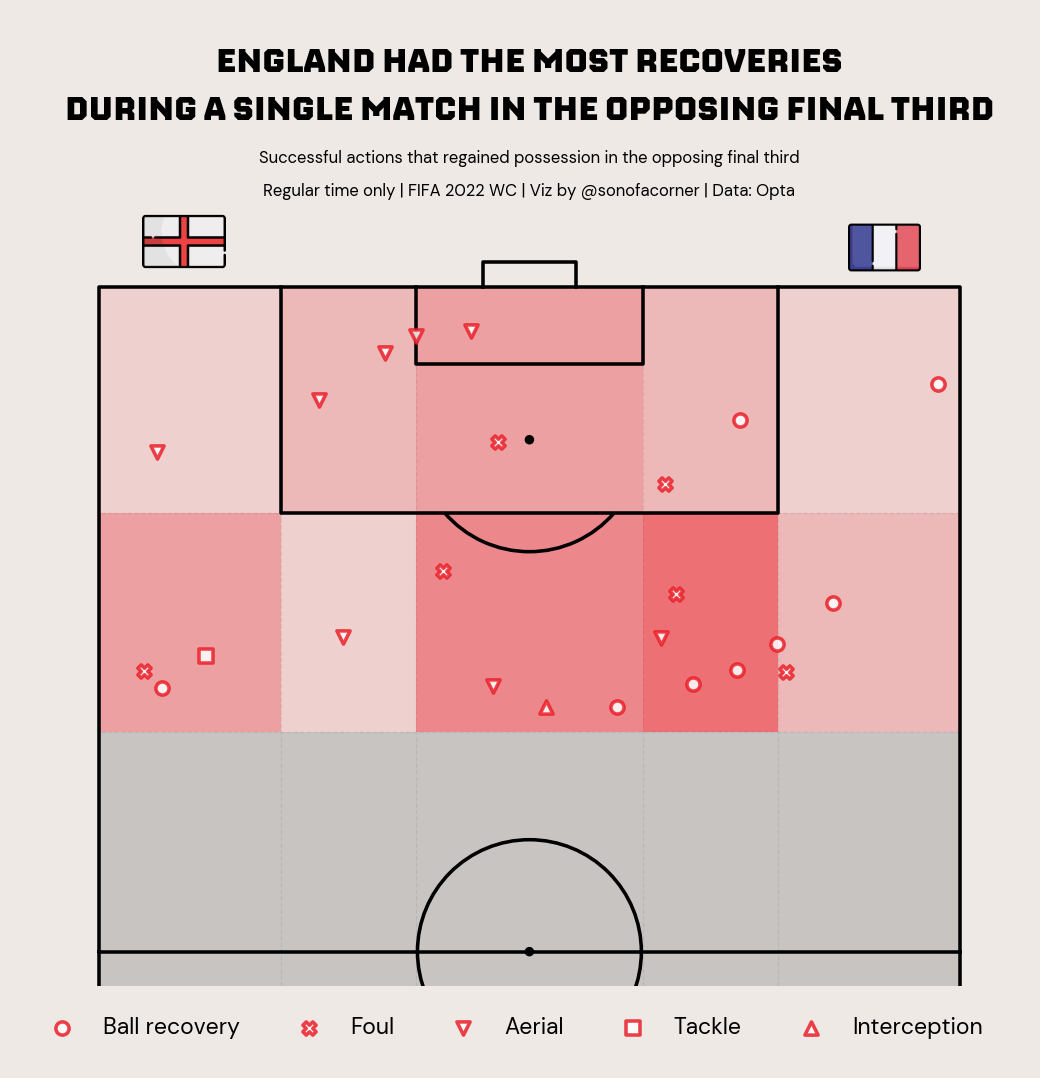

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=.85,
    line_color='black',
    half=True
)
pitch.draw(ax = ax)

# Here we can get the positional dimensions
pos_x = pitch.dim.positional_x
pos_y = pitch.dim.positional_y

# Remember that we need to invert the axis!!
for x in pos_x[1:-1]:
    ax.plot([pos_y[0], pos_y[-1]], [x,x], color='lightgrey', ls='dashed', zorder=0, lw=0.3, alpha=0.85)
for y in pos_y[1:-1]:
    ax.plot([y,y], [pos_x[0], pos_x[-1]], color='lightgrey', ls='dashed', zorder=0, lw=0.3, alpha=0.85)

counter = 1
for index_y, y in enumerate(pos_y):
    for index_x, x in enumerate(pos_x):
        try:
            lower_y = pos_y[index_y]
            lower_x = pos_x[index_x]
            upper_y = pos_y[index_y + 1]
            upper_x = pos_x[index_x + 1]
        except:
            continue
        condition_bounds = (data_eng_groupped['left_x'] >= lower_x) & (data_eng_groupped['right_x'] <= upper_x) & (data_eng_groupped['left_y'] >= lower_y) & (data_eng_groupped['right_y'] <= upper_y)
        alpha = data_eng_groupped[condition_bounds]['count'].iloc[0]/data_eng_groupped['count'].max()
        if alpha > 0:
            ax.fill_between(
                x=[lower_y, upper_y],
                y1=lower_x,
                y2=upper_x,
                color='#EA1F29',
                zorder=0,
                alpha=alpha*.6,
                ec='None'
            )
        else:
            ax.fill_between(
                x=[lower_y, upper_y],
                y1=lower_x,
                y2=upper_x,
                color='grey',
                zorder=0,
                alpha=.35,
                ec='None'
            )
        counter += 1


actions = ['BallRecovery', 'Foul', 'Aerial', 'Tackle', 'Interception']
markers = ['o', 'X', 'v', 's', '^']
for a, m in zip(actions, markers):
    if a == 'BallRecovery':
        a_label = 'Ball recovery'
    else:
        a_label = a
    ax.scatter(data_eng[data_eng['event_type'] == a].y, data_eng[data_eng['event_type'] == a].x, 
    s=10, alpha=0.85, lw=0.85, fc='#FFFFFF', ec='#EA1F29', zorder=3, marker=m, label=a_label)

ax.legend(ncol=5, loc='lower center', fontsize=5.5, bbox_to_anchor=[.48, -.1])

# -- Add Fancy Logo and Text
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
ax_coords = DC_to_NFC((95,95))
ax_size = .07
image_ax = fig.add_axes(
    [ax_coords[0], ax_coords[1], ax_size, ax_size],
    fc='None'
)
fotmob_url = 'https://cdn-icons-png.flaticon.com/512/491/491560.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax_coords = DC_to_NFC((13,95))
ax_size = .06
image_ax = fig.add_axes(
    [ax_coords[0], ax_coords[1], ax_size, ax_size],
    fc='None'
)
fotmob_url = 'https://cdn-icons-png.flaticon.com/512/3013/3013904.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
image_ax.imshow(club_icon)
image_ax.axis('off')

ax_text(
    x=50, y=112,
    s='ENGLAND HAD THE MOST RECOVERIES\nDURING A SINGLE MATCH IN THE OPPOSING FINAL THIRD',
    size=8, family='Nippo',
    ha='center', ax=ax, va='bottom', weight='bold', textalign='center'
)

ax_text(
    x=50, y=106.5,
    s='Successful actions that regained possession in the opposing final third\nRegular time only | FIFA 2022 WC | Viz by @sonofacorner | Data: Opta',
    size=4, family='DM Sans',
    ha='center', ax=ax, va='bottom', weight='normal', textalign='center'
)

plt.savefig(
	"figures/12232022_most_recoveries.png",
	dpi = 600,
	facecolor = "None",
	bbox_inches="tight",
    edgecolor="none",
	transparent=True
)

## Viz 3. Contested Zones

For the final visual we'll explore the contested zones for all matches played by the Canadian national team during the World Cup.

In [99]:
data_contested = data.copy()

We define a function that cuts and groups the data so we can check who had the most possession on each area.

In [114]:
def compute_contested_zones(match_id, team_name, data=data_contested):
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.1,
        line_color='black',
        pad_top=10,
        corner_arcs=True
    )
    # Here we can get the positional dimensions
    pos_x = pitch.dim.positional_x
    pos_y = pitch.dim.positional_y
    df = data.copy()
    df_match = df[df['match_id'] == match_id]
    # -- Adjust opposition figures
    df_match.loc[:,'x'] = [100 - x if y != team_name else x for x,y in zip(df_match['x'], df_match['team_name'])]
    df_match.loc[:,'y'] = [100 - x if y != team_name else x for x,y in zip(df_match['y'], df_match['team_name'])]
    df_match = df_match.assign(bins_x = lambda x: pd.cut(x.x, bins=pos_x))
    df_match = df_match.assign(bins_y = lambda x: pd.cut(x.y, bins=list(pos_y) + [105]))
    df_match_groupped = df_match.groupby(['bins_x', 'bins_y', 'team_name', 'match_id'])['is_touch'].sum().reset_index(name='touches')
    df_team = df_match_groupped[df_match_groupped['team_name'] == team_name]
    df_oppo = df_match_groupped[df_match_groupped['team_name'] != team_name].rename(columns={'team_name':'opp_name', 'touches':'opp_touches'})
    df_plot = pd.merge(df_team, df_oppo, on=['bins_x', 'bins_y'])
    df_plot = df_plot.assign(ratio = lambda x: x.touches/(x.touches + x.opp_touches))
    df_plot['left_x'] = df_plot['bins_x'].apply(lambda x: x.left).astype(float)
    df_plot['right_x'] = df_plot['bins_x'].apply(lambda x: x.right).astype(float)
    df_plot['left_y'] = df_plot['bins_y'].apply(lambda x: x.left).astype(float)
    df_plot['right_y'] = df_plot['bins_y'].apply(lambda x: x.right).astype(float)
    return df_plot

In [115]:
data_contested[data_contested['match_string'].str.contains('Canada')][['match_id', 'match_string']].drop_duplicates()

,match_id,match_string
20586,1632113,Canada - Morocco
47738,1632108,Belgium - Canada
71171,1632111,Croatia - Canada


In [116]:
compute_contested_zones(1632113, 'Canada')['touches'].sum()

/Users/miguel/Documents/Personal/Son of a corner/soc-viz-of-the-week/.venv/lib/python3.10/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


697

Next, we test our function.

For the final step, we define another function that plots our data for a single fixture.

In [119]:
def plot_zone_dominance(ax, match_id, team_name, df=data_contested):
    data_plot = df.copy()
    data_plot = compute_contested_zones(match_id, team_name, data=data_plot)
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.1,
        line_color='black',
        pad_top=10,
        corner_arcs=True
    )
    pitch.draw(ax = ax)

    # Here we can get the positional dimensions
    pos_x = pitch.dim.positional_x
    pos_y = pitch.dim.positional_y

    for index_y, y in enumerate(pos_y):
        for index_x, x in enumerate(pos_x):
            try:
                lower_y = pos_y[index_y]
                lower_x = pos_x[index_x]
                upper_y = pos_y[index_y + 1]
                upper_x = pos_x[index_x + 1]
                condition_bounds = (data_plot['left_x'] >= lower_x) & (data_plot['right_x'] <= upper_x) & (data_plot['left_y'] >= lower_y) & (data_plot['right_y'] <= upper_y)
                data_point = data_plot[condition_bounds]['ratio'].iloc[0]
                if data_point > .55:
                    color = '#3E5641'
                elif data_point < .45:
                    color = '#461220'
                else:
                    color = '#FCB9B2'
                ax.fill_between(
                    x=[lower_y, upper_y],
                    y1=lower_x,
                    y2=upper_x,
                    color=color,
                    zorder=0,
                    alpha=0.75,
                    ec='None'
                )
            except:
                continue

    ax_text(
        x=100,y=115,
        s=f"{data_plot['team_name'].iloc[0].upper()} vs. {data_plot['opp_name'].iloc[0].upper()}",
        color='black',
        ha='left',
        va='center',
        weight='bold',
        size=10,
        ax=ax
    )

    # Remember that we need to invert the axis!!
    for x in pos_x[1:-1]:
        ax.plot([pos_y[0], pos_y[-1]], [x,x], color='black', ls='dashed', zorder=0, lw=0.3, alpha=0.85)
    for y in pos_y[1:-1]:
        ax.plot([y,y], [pos_x[0], pos_x[-1]], color='black', ls='dashed', zorder=0, lw=0.3, alpha=0.85)

    return ax

Time to visualize the data!

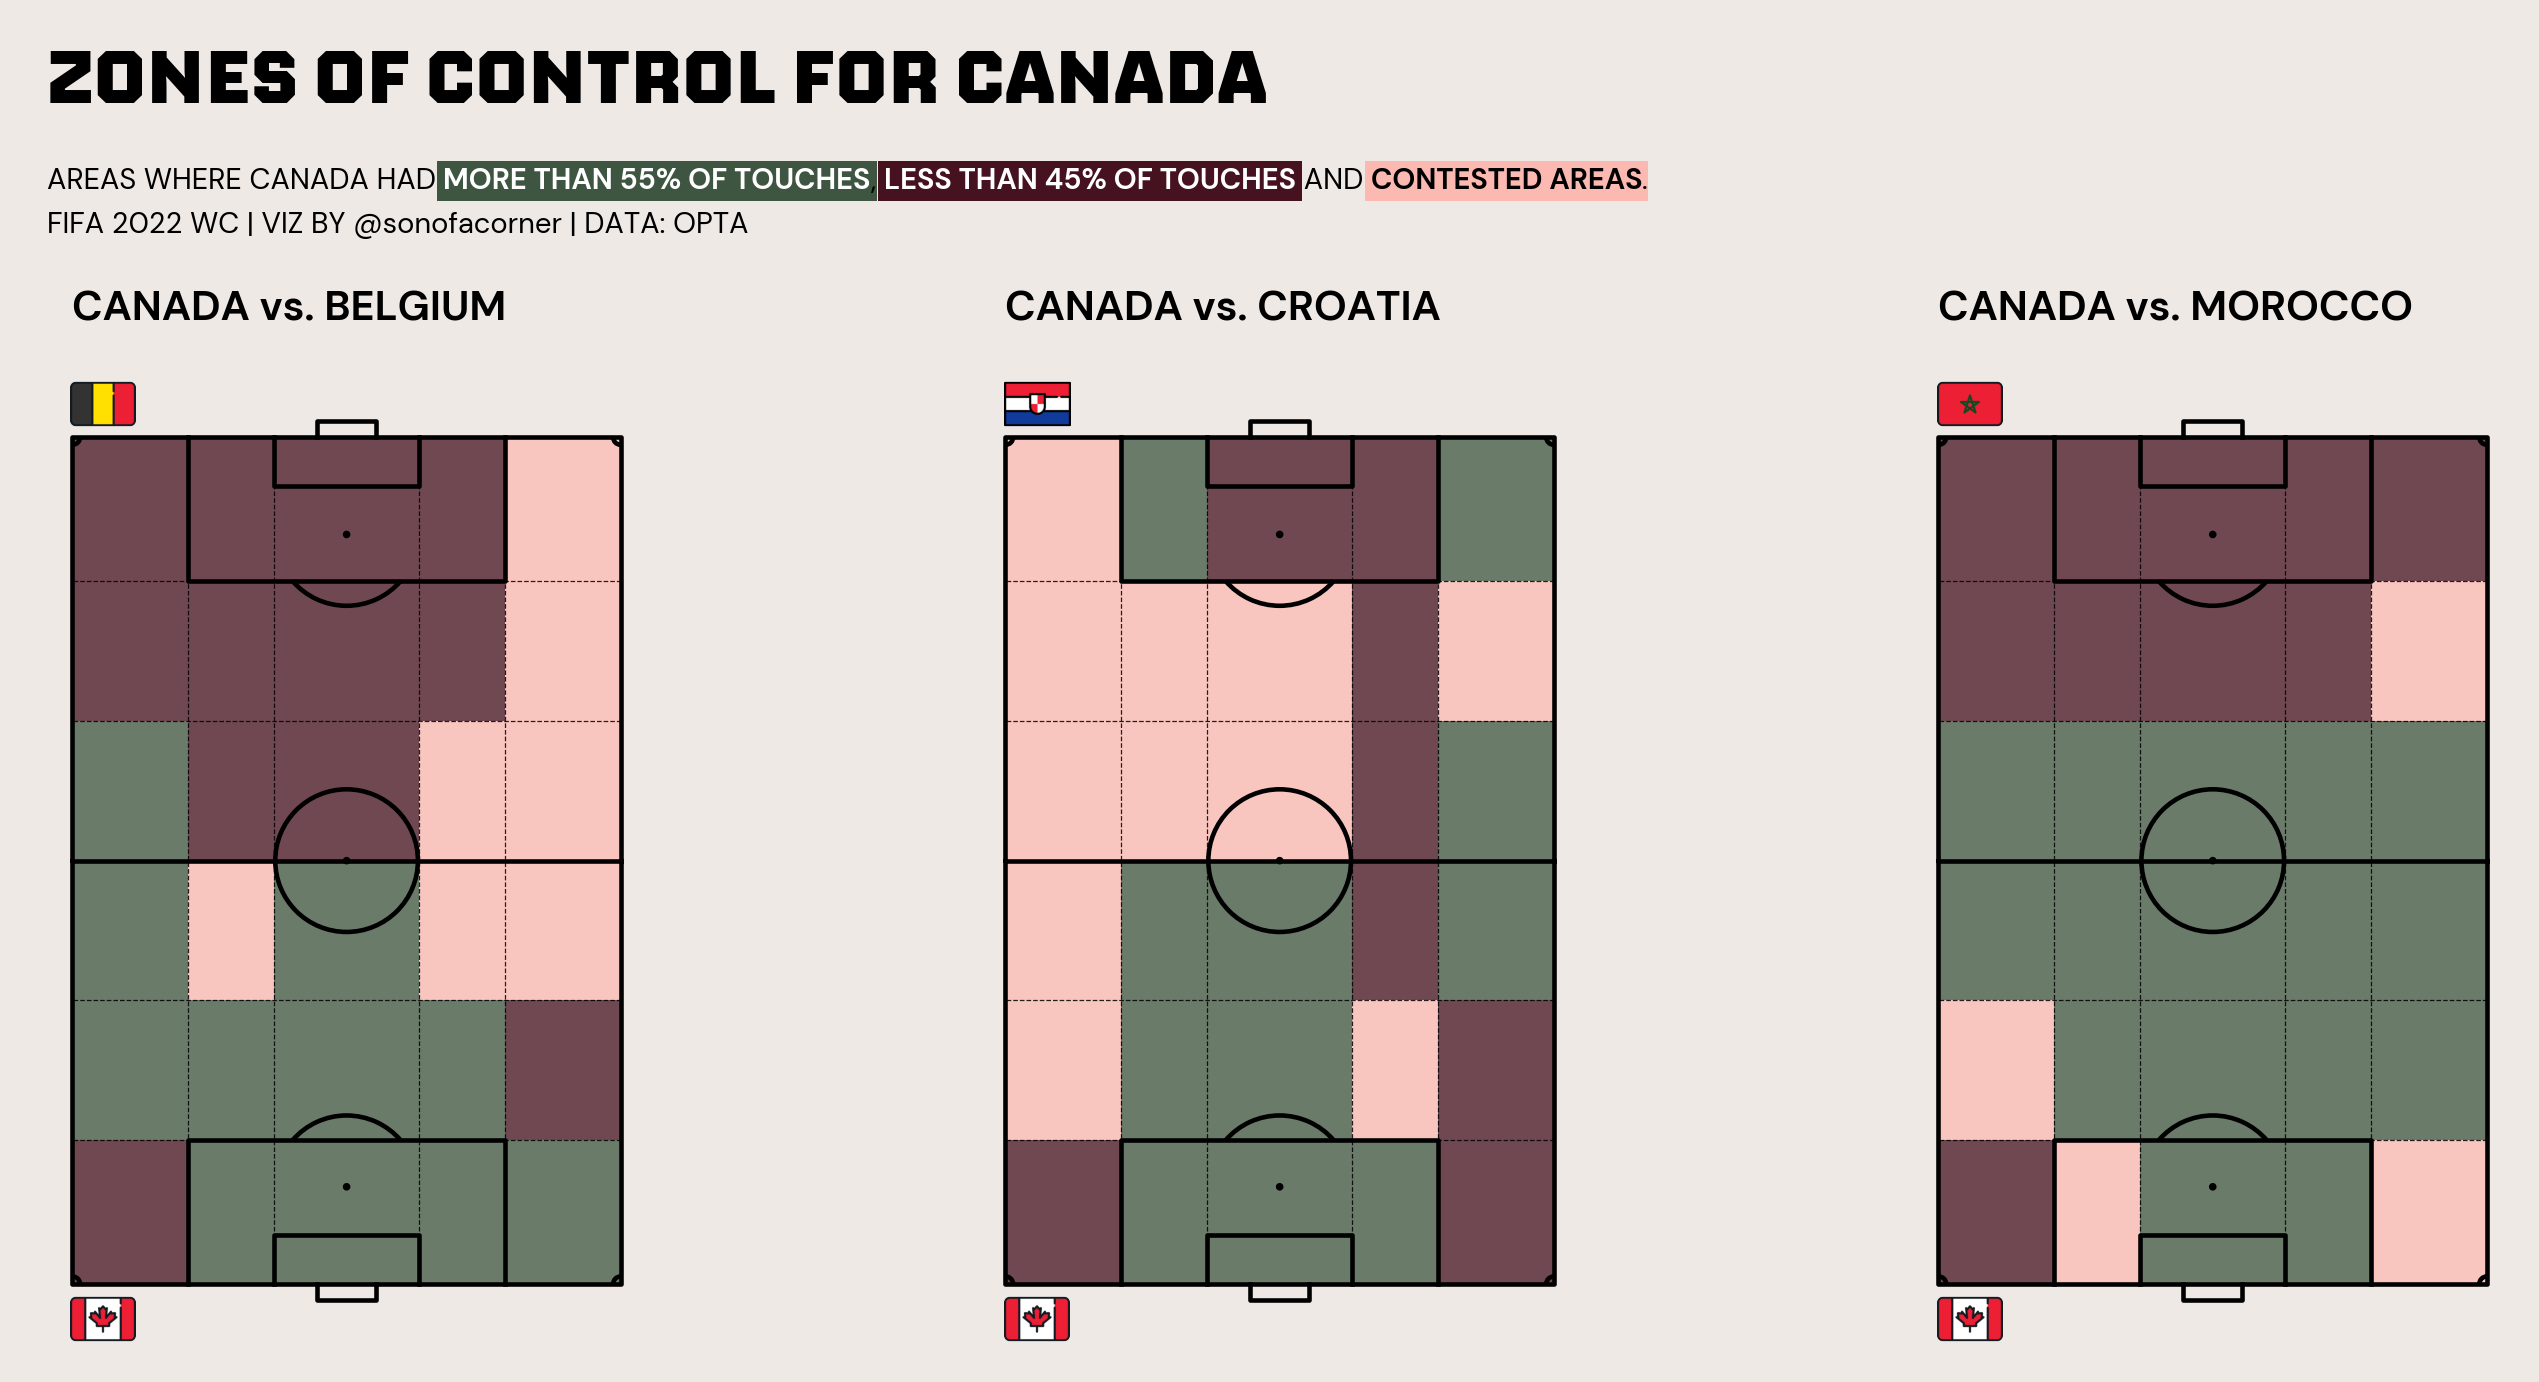

In [164]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=300)
plot_zone_dominance(axs[0], 1632108, 'Canada')
plot_zone_dominance(axs[1], 1632111, 'Canada')
plot_zone_dominance(axs[2], 1632113, 'Canada')

plt.subplots_adjust(wspace=.01)
other_flags = [
    'https://cdn-icons-png.flaticon.com/512/317/317098.png',
    'https://cdn-icons-png.flaticon.com/512/164/164946.png',
    'https://cdn-icons-png.flaticon.com/512/317/317251.png',
]
for i, flag in enumerate(other_flags):
    # -- Add Fancy Logo and Text
    DC_to_FC = axs[i].transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((90,-8))
    ax_size = .055
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://cdn-icons-png.flaticon.com/512/317/317142.png'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    ax_coords = DC_to_NFC((90,100))
    ax_size = .055
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    club_icon = Image.open(urllib.request.urlopen(f'{flag}'))
    image_ax.imshow(club_icon)
    image_ax.axis('off')


fig_text(
    x=0.17, y=1.1,
    s='ZONES OF CONTROL FOR CANADA',
    size=18, family='Nippo',
    va='bottom', weight='bold'
)

bbox_pad = 1.5
bboxprops = {'linewidth': 0, 'pad': bbox_pad}


fig_text(
    x=0.17, y=1.0,
    s='AREAS WHERE CANADA HAD <MORE THAN 55% OF TOUCHES>, <LESS THAN 45% OF TOUCHES> AND <CONTESTED AREAS>.\nFIFA 2022 WC | VIZ BY @sonofacorner | DATA: OPTA',
    size=7, family='DM Sans',
    va='bottom', weight='normal',
        highlight_textprops=[
        {'color': 'w', 'weight': 'bold', 'bbox': {'facecolor':'#3E5641', **bboxprops}},
        {'color': 'w', 'weight': 'bold', 'bbox': {'facecolor':'#461220', **bboxprops}},
        {'color': 'black', 'weight': 'bold', 'bbox': {'facecolor':'#FCB9B2', **bboxprops}},
    ]
)

plt.savefig(
	"figures/12232022_control_zones.png",
	dpi = 600,
	facecolor = "None",
	bbox_inches="tight",
    edgecolor="none",
	transparent=True
)